## Implement  Variational Autoencoder for Image Attribute Manipulation with CelebA
The objective of this homework is to implement a Variational Autoencoder (VAE) in PyTorch and use it for image attribute manipulation on the CelebA dataset.

For example: Change hair color or add glasses

##Dataset:
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

*   10,177 number of identities,
*   202,599 number of face images, and
*   5 landmark locations, 40 binary attributes annotations per image.



##Tasks:

1. Implement a conditional VAE (CVAE) that can manipulate image attributes.
2. Train the VAE on the CelebA dataset. Hint: VAE will be conditional VAE
3. Manipulate specific attributes of the images.
4. Evaluate and visualize the results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CelebA
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
import os
from torch.utils.data import Dataset # Import the Dataset class
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import os
from PIL import Image

# 1.Dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content
%cd /content/drive/MyDrive/CelebA

/content
/content/drive/MyDrive/CelebA


In [ ]:
#!unzip /content/drive/MyDrive/CelebA/img_align_celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [9]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.attrs = self.load_attributes(attr_path)
        self.imgs = sorted(os.listdir(self.img_dir))  # Ensure sorted to match the attribute file order

    def load_attributes(self, attr_path):
        with open(attr_path, 'r') as f:
            lines = f.readlines()
            attr_names = lines[1].split()
            attrs = {}
            for line in lines[2:]:
                parts = line.split()
                img_name = parts[0]
                # Convert -1 to 0 in the attributes
                attr_values = [0 if x.strip() == '-1' else 1 for x in parts[1:]]  # Handle hyphens and convert to integers
                attrs[img_name] = torch.tensor(attr_values, dtype=torch.float32)
        return attrs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        attributes = self.attrs[img_name]
        return image, attributes

## DataLoader

In [11]:
# DataLoader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CelebADataset(img_dir='/content/drive/MyDrive/CelebA/img_align_celeba', attr_path='/content/drive/MyDrive/CelebA/list_attr_celeba.txt', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers= 4)

#2.CVAE


> This allows the model to generate new images that are consistent with the input attributes or to manipulate the attributes of existing images.




- implementation of a Conditional Variational Autoencoder (CVAE)

- encode : This method takes the input image x and the corresponding attributes c, and encodes them into the mean and log-variance of the latent representation z.

- reparameterize : This method uses the reparameterization trick to sample a latent variable z from the Gaussian distribution defined by the mean mu and log-variance logvar.

- decode : This method takes the sampled latent variable z and the attributes c, and decodes them into a reconstructed image.

In [12]:
class CVAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=100, attr_dim=40):
        super(CVAE, self).__init__()

        self.image_channels = image_channels
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.attr_dim = attr_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels + attr_dim, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # calculates the size of the flattened feature map produced by the convolutional encoder.
        self.feature_size = self._get_conv_output((image_channels + attr_dim, 64, 64))

        self.fc_mu = nn.Linear(self.feature_size + attr_dim, z_dim)
        self.fc_logvar = nn.Linear(self.feature_size + attr_dim, z_dim)

        self.decoder_input = nn.Linear(z_dim + attr_dim, self.feature_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self.encoder(input)
        return int(output.numel() / output.size(0))

    def encode(self, x, c):
        c_expanded = c.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x_c = torch.cat([x, c_expanded], dim=1)
        h = self.encoder(x_c)
        h_flat = h.view(h.size(0), -1)
        h_c = torch.cat([h_flat, c], dim=1)
        return self.fc_mu(h_c), self.fc_logvar(h_c)

    # Gaussian distribution defined by the mean mu and log-variance logvar.
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_c = torch.cat([z, c], dim=1)
        h = self.decoder_input(z_c)
        h = h.view(h.size(0), 256, 4, 4)  # Reshape to match the encoder output shape
        return self.decoder(h)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

##loss

- Kullback-Leibler (KL) Divergence Loss:
This term measures the difference between the distribution of the latent variables z and a standard normal distribution.

- Reconstruction Loss (BCE):
This term represents the error between the reconstructed output recon_x and the original input x.

In [13]:
import torch.nn.functional as F
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 3.Train the VAE

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, attr) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        attr = attr.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, attr)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}')

# Save the model
torch.save(model.state_dict(), 'cvae_celeba.pth')

100%|██████████| 700/700 [2:10:58<00:00, 11.23s/it]


Epoch 1, Loss: 1191.0852


100%|██████████| 700/700 [01:13<00:00,  9.47it/s]


Epoch 2, Loss: 709.0232


100%|██████████| 700/700 [01:14<00:00,  9.40it/s]


Epoch 3, Loss: 579.7376


100%|██████████| 700/700 [01:13<00:00,  9.50it/s]


Epoch 4, Loss: 543.2253


100%|██████████| 700/700 [01:13<00:00,  9.58it/s]


Epoch 5, Loss: 525.1129


100%|██████████| 700/700 [01:13<00:00,  9.47it/s]


Epoch 6, Loss: 512.0011


100%|██████████| 700/700 [01:14<00:00,  9.36it/s]


Epoch 7, Loss: 502.6787


100%|██████████| 700/700 [01:14<00:00,  9.45it/s]


Epoch 8, Loss: 495.3291


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 9, Loss: 489.1116


100%|██████████| 700/700 [01:13<00:00,  9.50it/s]


Epoch 10, Loss: 483.6524


100%|██████████| 700/700 [01:13<00:00,  9.53it/s]


Epoch 11, Loss: 477.9063


100%|██████████| 700/700 [01:13<00:00,  9.48it/s]


Epoch 12, Loss: 474.6473


100%|██████████| 700/700 [01:13<00:00,  9.53it/s]


Epoch 13, Loss: 470.6620


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 14, Loss: 468.0613


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 15, Loss: 465.9502


100%|██████████| 700/700 [01:14<00:00,  9.43it/s]


Epoch 16, Loss: 463.7886


100%|██████████| 700/700 [01:14<00:00,  9.35it/s]


Epoch 17, Loss: 462.5681


100%|██████████| 700/700 [01:13<00:00,  9.48it/s]


Epoch 18, Loss: 460.8839


100%|██████████| 700/700 [01:14<00:00,  9.44it/s]


Epoch 19, Loss: 458.7693


100%|██████████| 700/700 [01:14<00:00,  9.43it/s]

Epoch 20, Loss: 458.5116


In [ ]:
model.load_state_dict(torch.load('cvae_celeba.pth'))
model.eval()

# 4.visualize the results

- 'Smiling' attribute is set to 1 for all the faces, and the model is able to reconstruct the images accordingly, preserving the overall facial features while changing the expression to a smiling one.

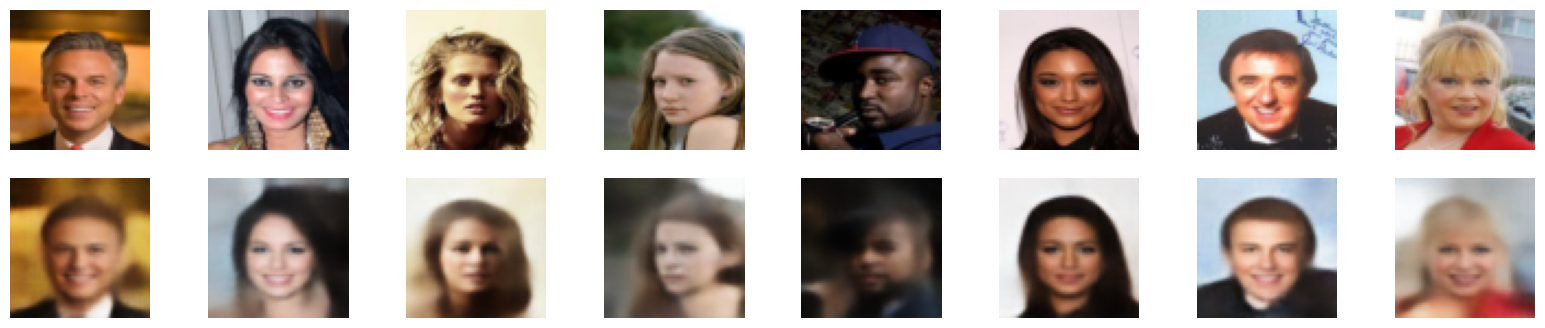

In [ ]:
# image smile original and reconstructed images

# Get a batch of test data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Modify labels to have smiling faces
labels[:, 18] = 1  # Set the 'Smiling' attribute to 1

# Reconstruct images with the modified labels
with torch.no_grad():
  recon_images, _, _ = model(images.to(device), labels.to(device))

# Display the original and reconstructed images
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

  # Display reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(recon_images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

plt.show()


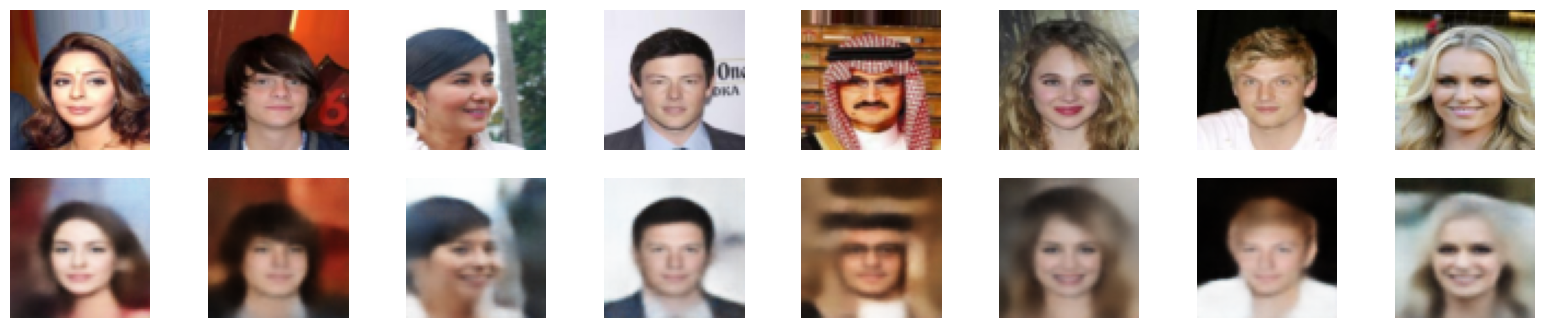

In [ ]:
# Plot the reconstructions Original test images"

# Get a batch of test data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Reconstruct images from the test data
with torch.no_grad():
  recon_images, _, _ = model(images.to(device), labels.to(device))

# Display the original and reconstructed images
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

  # Display reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(recon_images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

plt.show()

# 5.manipulate the attributes
- creates a new attribute tensor by flipping the value of the specified attribute index (i.e., changing it from 0 to 1, or from 1 to 0).

- The interpolate_attribute function allows you to generate a series of images by gradually changing a specific attribute,

- flip_attribute function lets you create a version of the input image with the specified attribute flipped.

In [ ]:
def interpolate_attribute(model, image, attr, attr_idx, steps=10):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        attr = attr.unsqueeze(0).to(device)

        # Encode the image
        mu, _ = model.encode(image, attr)

        # Create interpolation steps
        alphas = torch.linspace(0, 1, steps)

        interpolated_images = []
        for alpha in alphas:
            interpolated_attr = attr.clone()
            interpolated_attr[0, attr_idx] = alpha
            decoded = model.decode(mu, interpolated_attr)
            interpolated_images.append(decoded.cpu())

    return torch.cat(interpolated_images, dim=0)

def flip_attribute(model, image, attr, attr_idx):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        attr = attr.unsqueeze(0).to(device)

        # Encode the image
        mu, _ = model.encode(image, attr)

        # Flip the specified attribute
        flipped_attr = attr.clone()
        flipped_attr[0, attr_idx] = 1 - flipped_attr[0, attr_idx]

        # Decode with the flipped attribute
        decoded = model.decode(mu, flipped_attr)

    return decoded.cpu()

- The attribute interpolation demonstrates how the image changes as the specified attribute value is gradually varied.

- attribute flipping shows the difference between the original image and the one with the target attribute flipped.

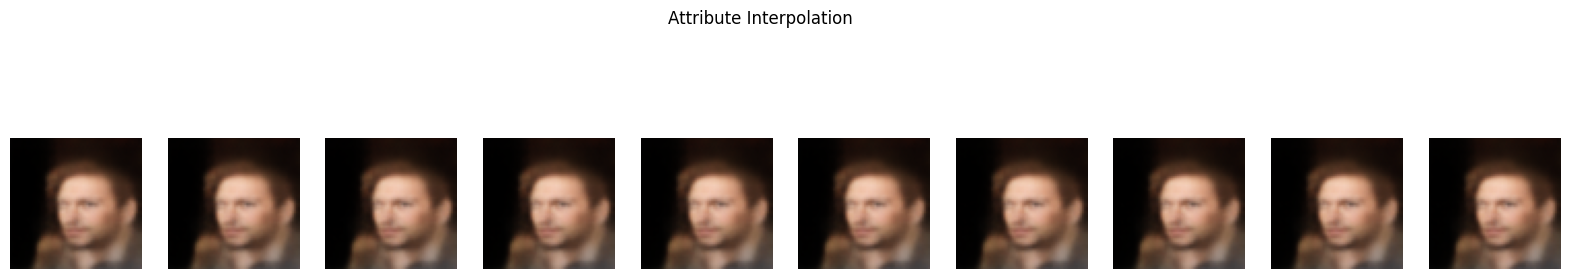

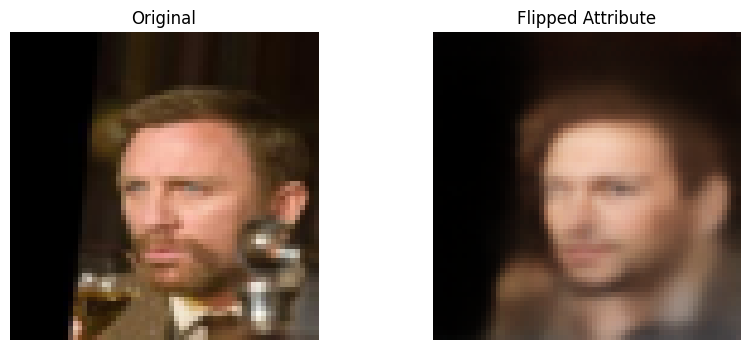

In [ ]:
import matplotlib.pyplot as plt

def show_image(img):
    img = img.permute(1, 2, 0)
    img = (img + 1) / 2  # Denormalize
    plt.imshow(img)
    plt.axis('off')

# Load a sample image and its attributes
sample_data, sample_attr = next(iter(dataloader))
sample_image = sample_data[0]
sample_attr = sample_attr[0]

# Interpolate an attribute (e.g., attribute index 0)
interpolated = interpolate_attribute(model, sample_image, sample_attr, attr_idx=0, steps=10)

# Visualize interpolation
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    show_image(interpolated[i])
plt.suptitle("Attribute Interpolation")


# Flip an attribute
flipped = flip_attribute(model, sample_image, sample_attr, attr_idx=0)

# Visualize original and flipped
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
show_image(sample_image)
plt.title("Original")
plt.subplot(1, 2, 2)
show_image(flipped[0])
plt.title("Flipped Attribute")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(images, num_images=10, title=""):
    device = images.device
    images = images.cpu()[:num_images]
    images = vutils.make_grid(images, nrow=num_images, normalize=True, scale_each=True)
    images = images.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 4))
    plt.imshow(images)
    plt.title(title)
    plt.axis('off')
    plt.show()

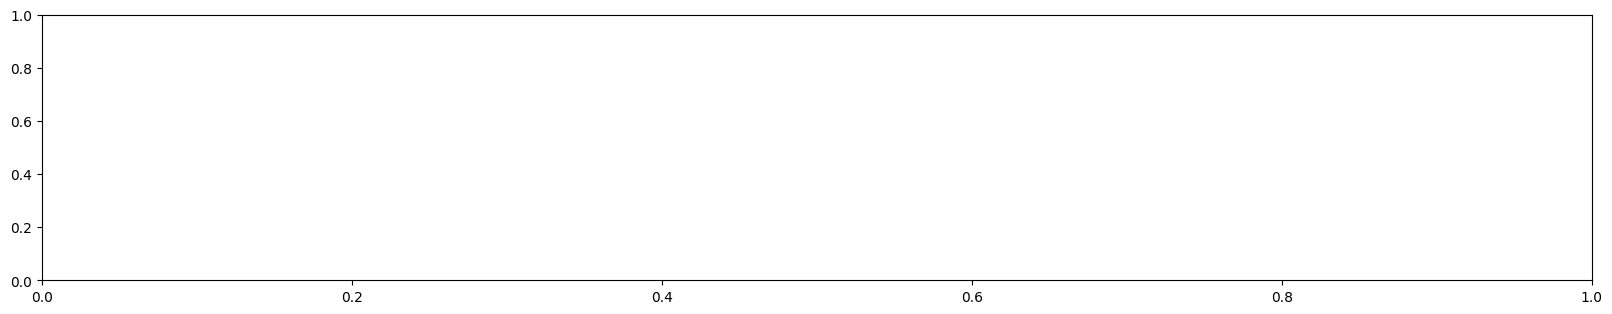

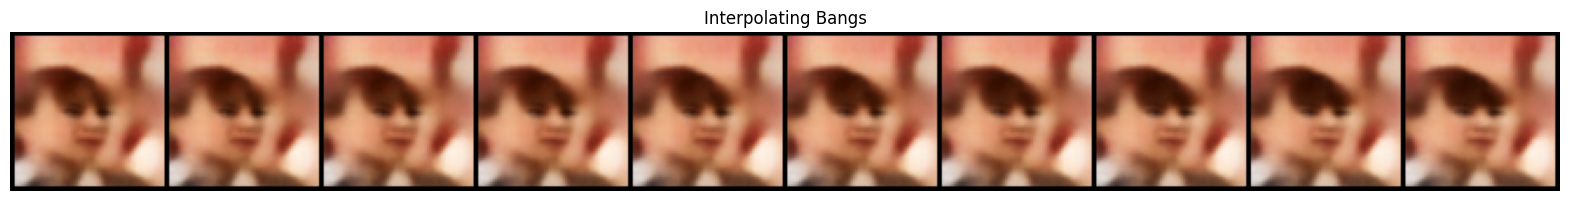

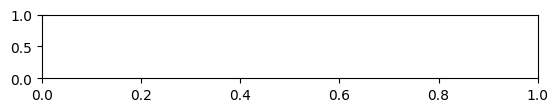

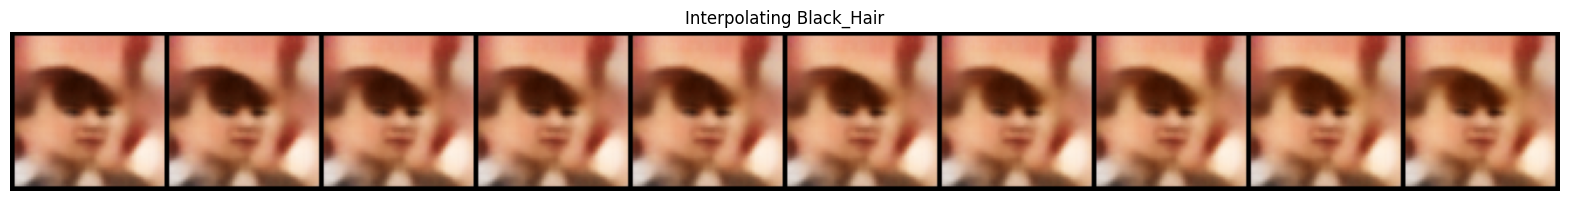

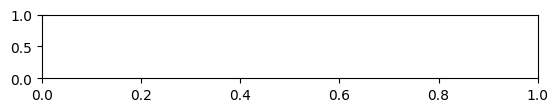

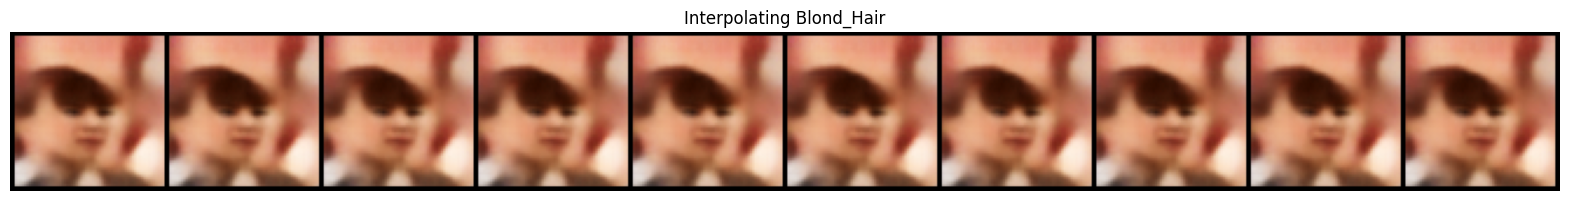

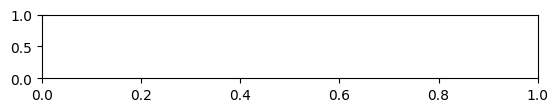

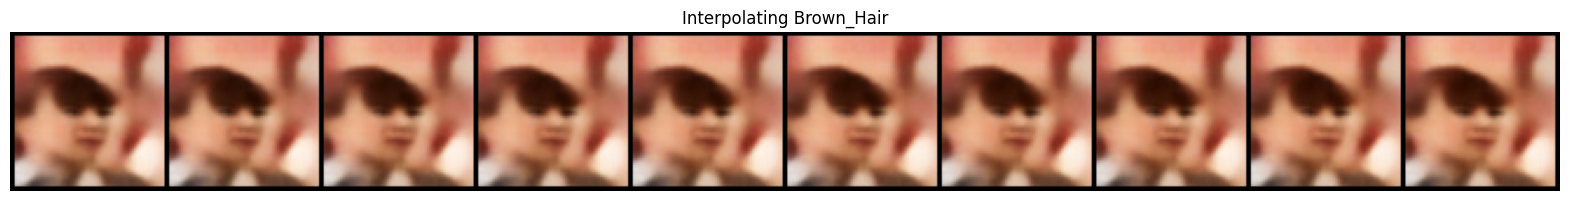

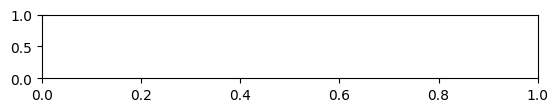

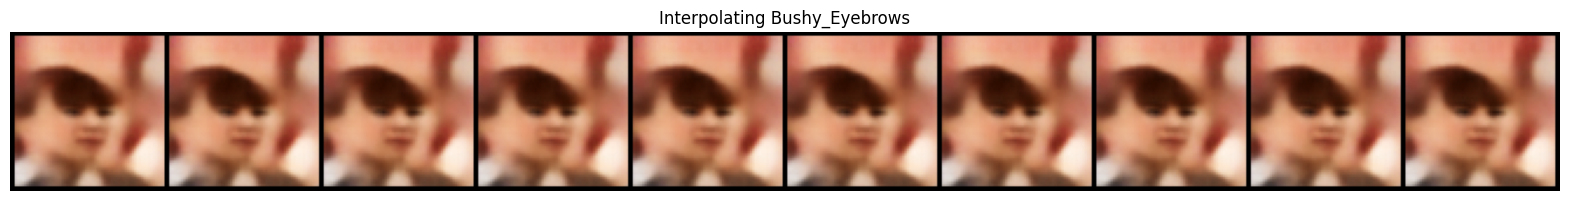

<Figure size 640x480 with 0 Axes>

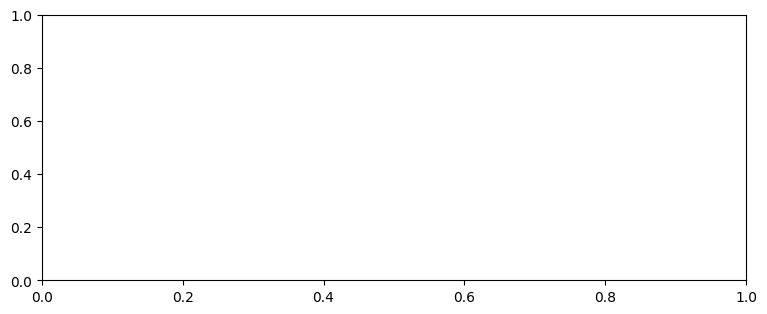

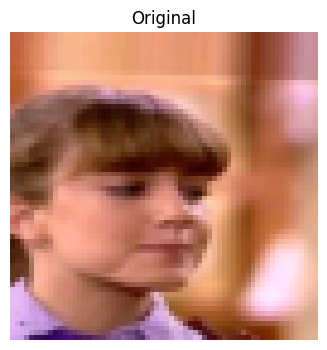

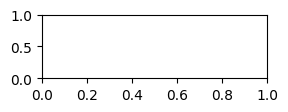

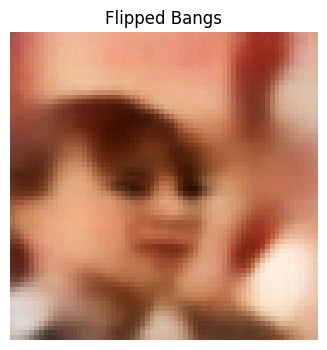

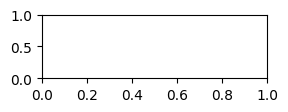

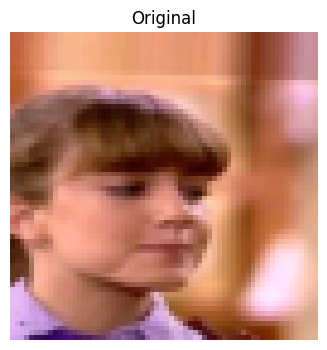

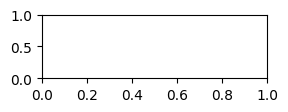

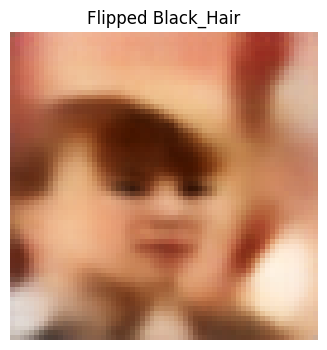

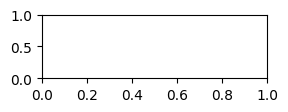

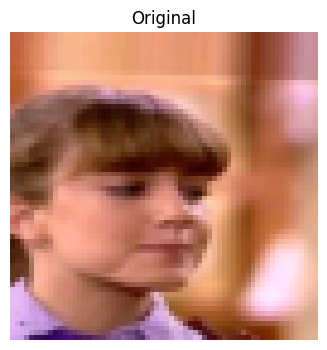

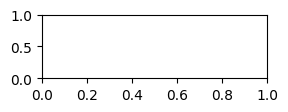

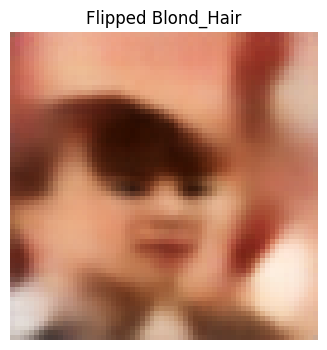

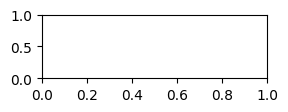

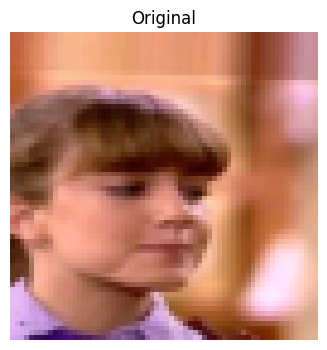

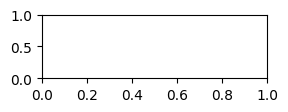

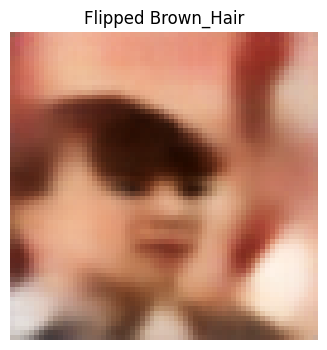

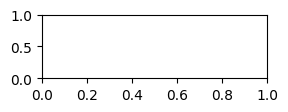

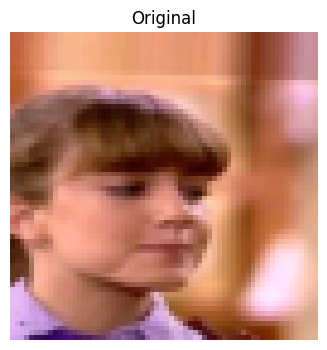

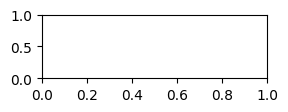

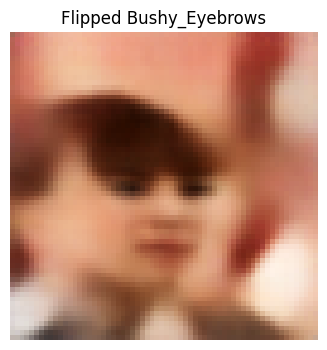

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load a batch of images and attributes
images, attrs = next(iter(dataloader))
sample_image = images[0].to(device)
sample_attr = attrs[0].to(device)

# List of attributes to manipulate (you can modify this based on CelebA attributes)
attribute_names = ["Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair", "Bushy_Eyebrows"]
attribute_indices = [5, 9, 10, 11, 12]  # Corresponding indices in the attribute vector

# Interpolate attributes
plt.figure(figsize=(20, 4*len(attribute_indices)))
for i, (attr_name, attr_idx) in enumerate(zip(attribute_names, attribute_indices)):
    interpolated = interpolate_attribute(model, sample_image, sample_attr, attr_idx, steps=10)
    plt.subplot(len(attribute_indices), 1, i+1)
    show_images(interpolated, title=f"Interpolating {attr_name}")
plt.tight_layout()
plt.show()

# Flip attributes
plt.figure(figsize=(20, 4*len(attribute_indices)))
for i, (attr_name, attr_idx) in enumerate(zip(attribute_names, attribute_indices)):
    flipped = flip_attribute(model, sample_image, sample_attr, attr_idx)
    plt.subplot(len(attribute_indices), 2, 2*i+1)
    show_images(sample_image.unsqueeze(0), title="Original")
    plt.subplot(len(attribute_indices), 2, 2*i+2)
    show_images(flipped, title=f"Flipped {attr_name}")
plt.tight_layout()
plt.show()

#6.Evaluate and visualize

- difference between the original image and the modified image.

- "Blond_Hair" attribute had the best (smallest) result, while the "Black_Hair" attribute had the worst (largest) result in terms of the magnitude of change due to the flipping operation.

In [ ]:
def evaluate_attribute_change(original, modified):
    modified = modified.to(original.device)
    diff = (modified - original).abs().mean().item()
    return diff

# Evaluate attribute changes
for attr_name, attr_idx in zip(attribute_names, attribute_indices):
    flipped = flip_attribute(model, sample_image, sample_attr, attr_idx)
    change = evaluate_attribute_change(sample_image, flipped[0])
    print(f"Attribute: {attr_name}, Change: {change:.4f}")

Attribute: Bangs, Change: 0.1374
Attribute: Black_Hair, Change: 0.1455
Attribute: Blond_Hair, Change: 0.1316
Attribute: Brown_Hair, Change: 0.1375
Attribute: Bushy_Eyebrows, Change: 0.1376


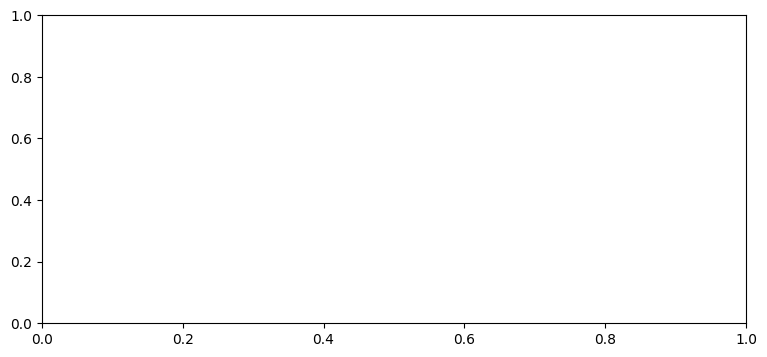

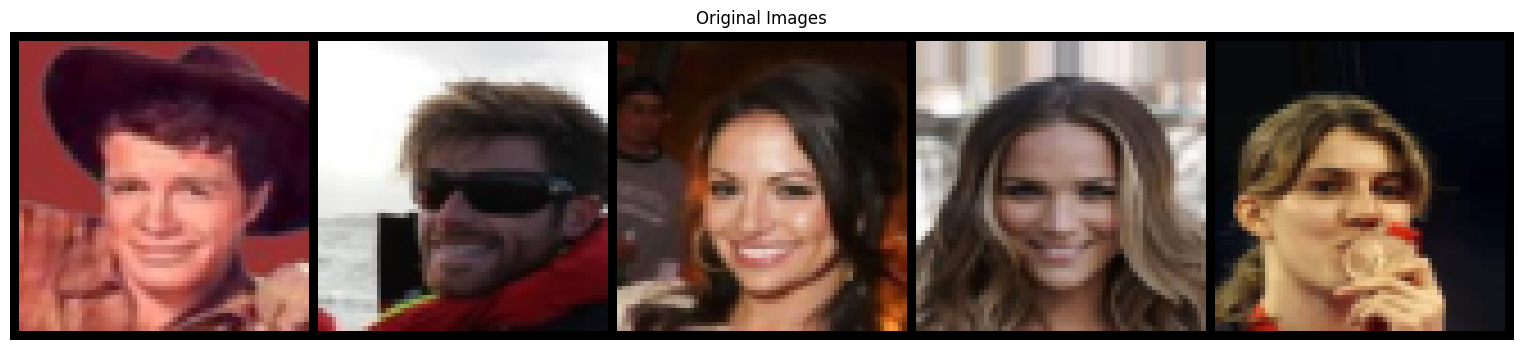

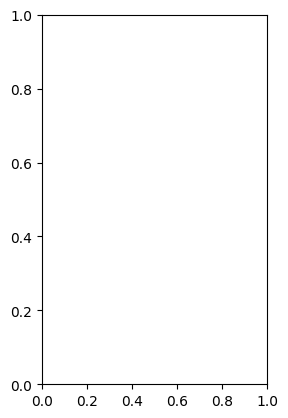

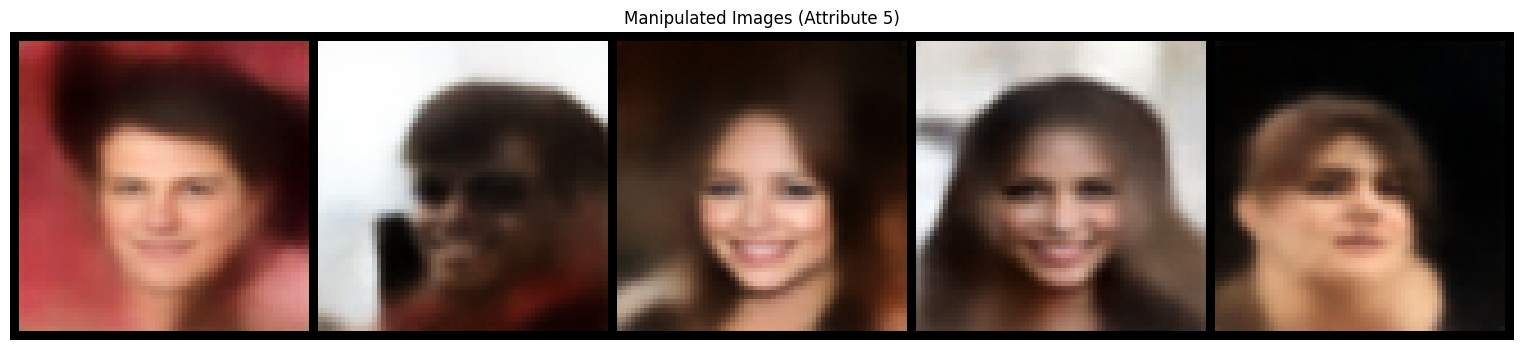

Manipulated attribute: Bangs


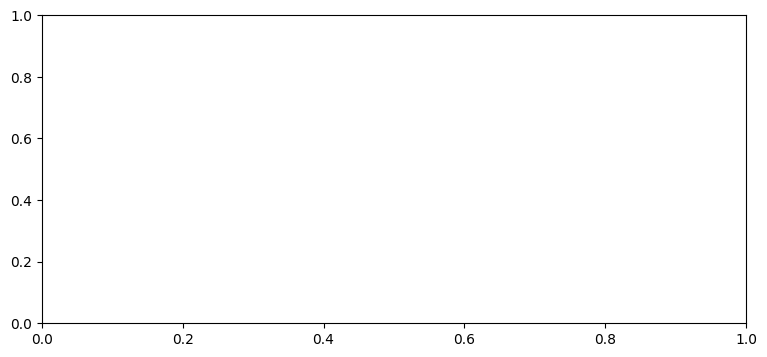

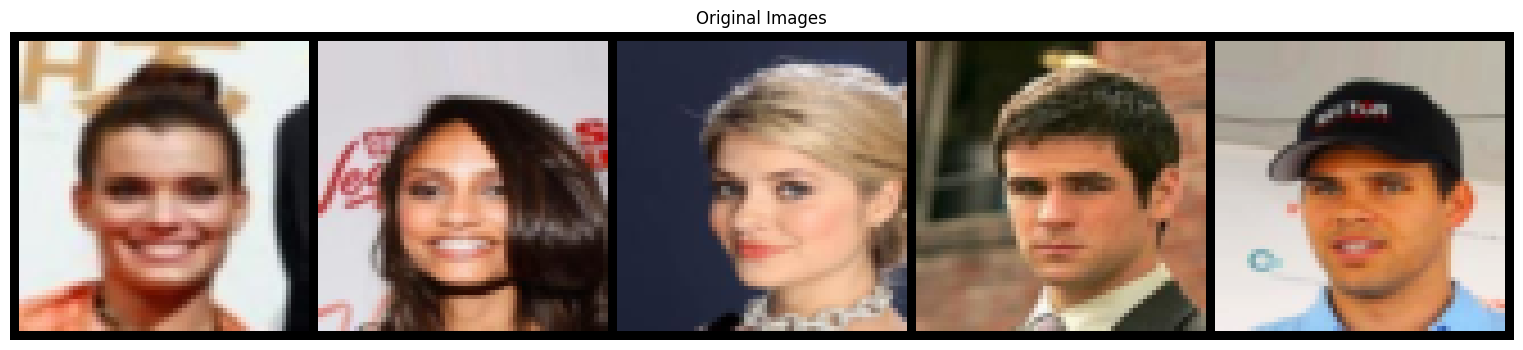

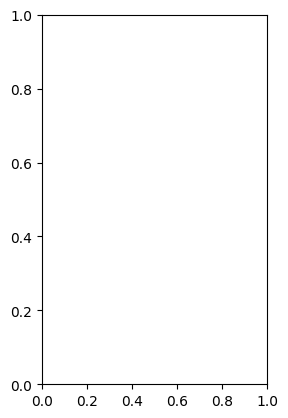

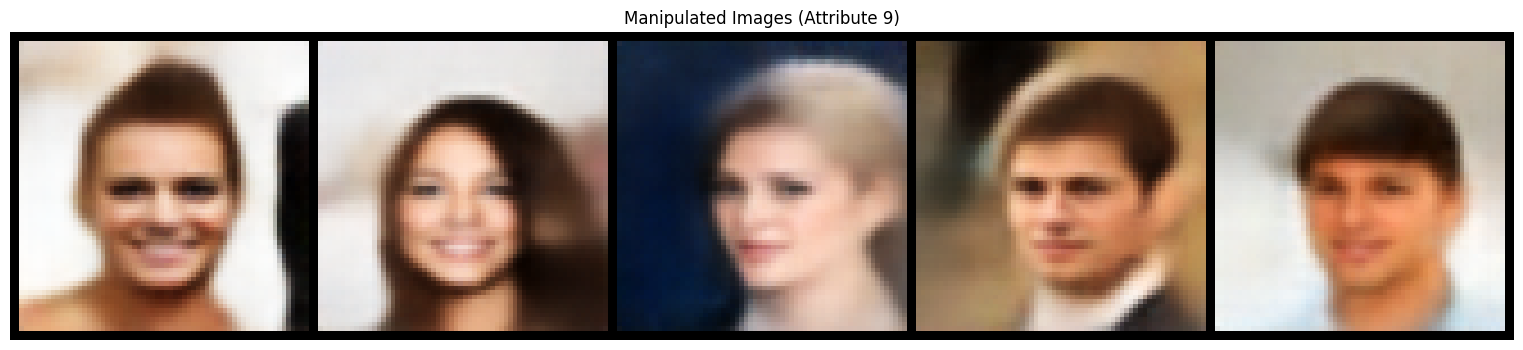

Manipulated attribute: Black_Hair


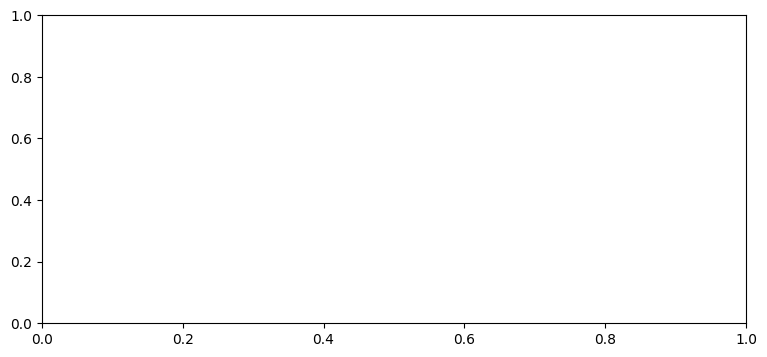

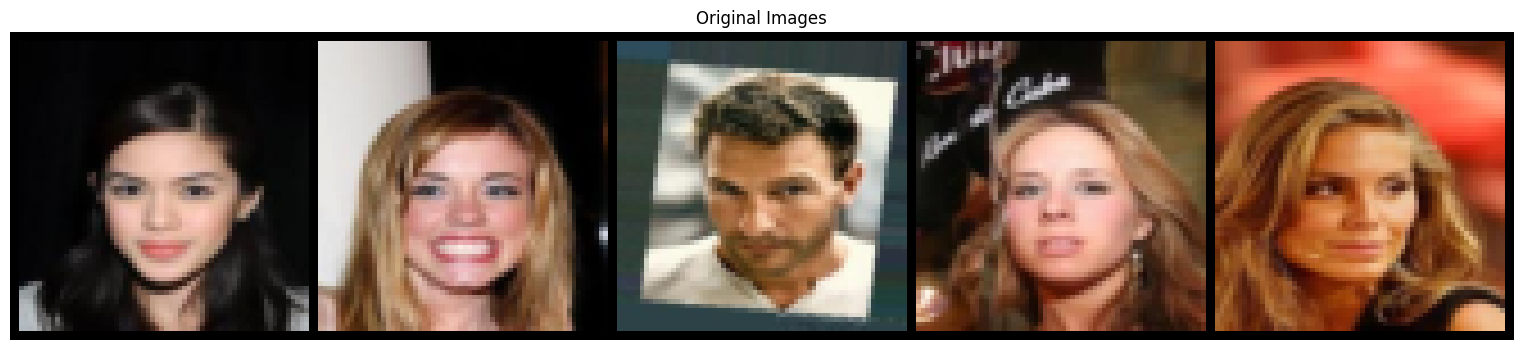

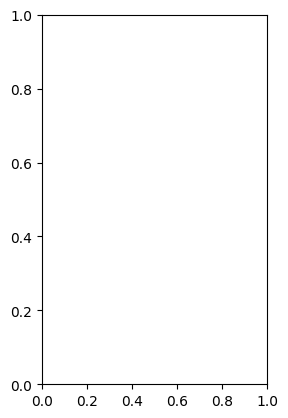

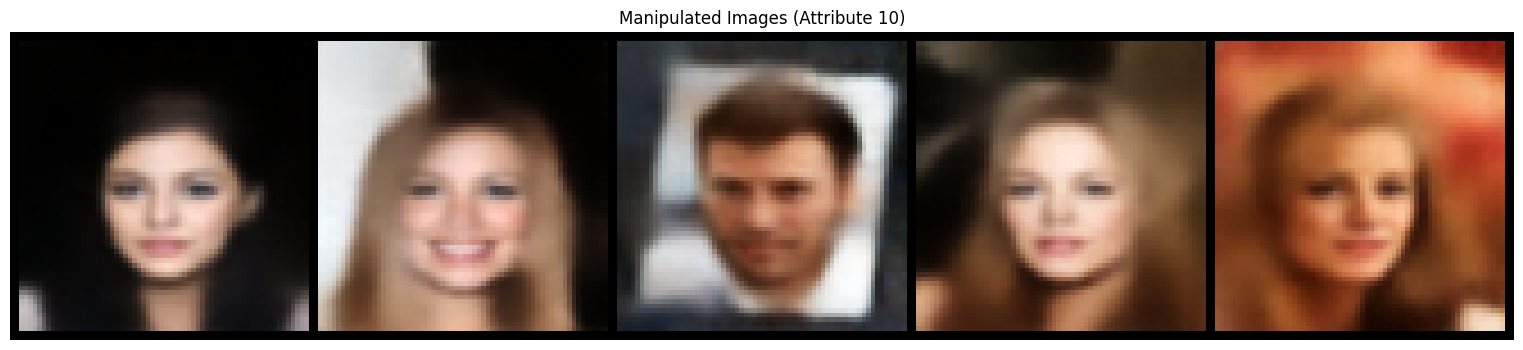

Manipulated attribute: Blond_Hair


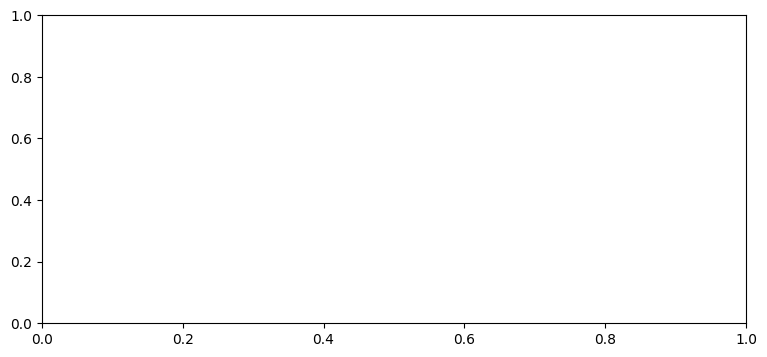

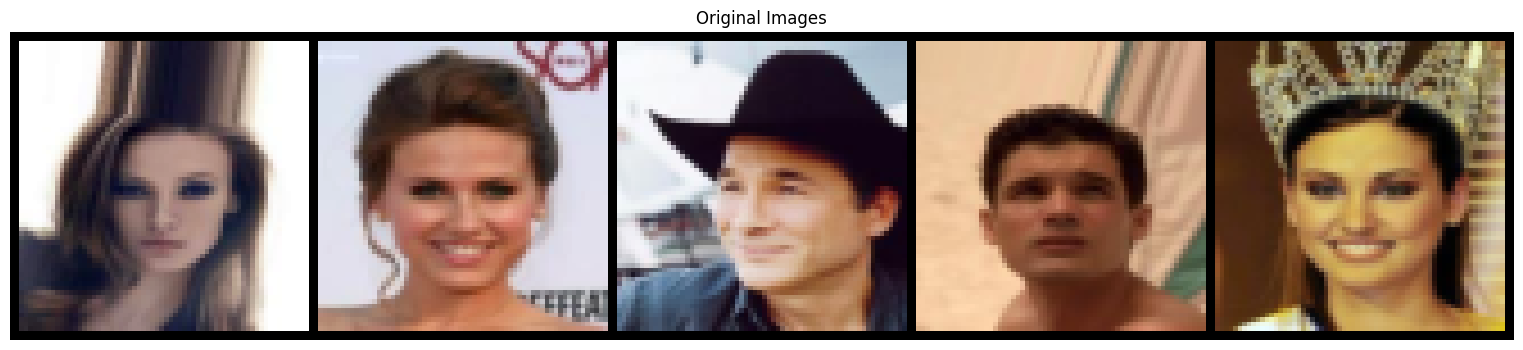

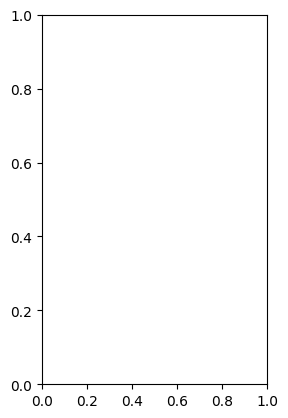

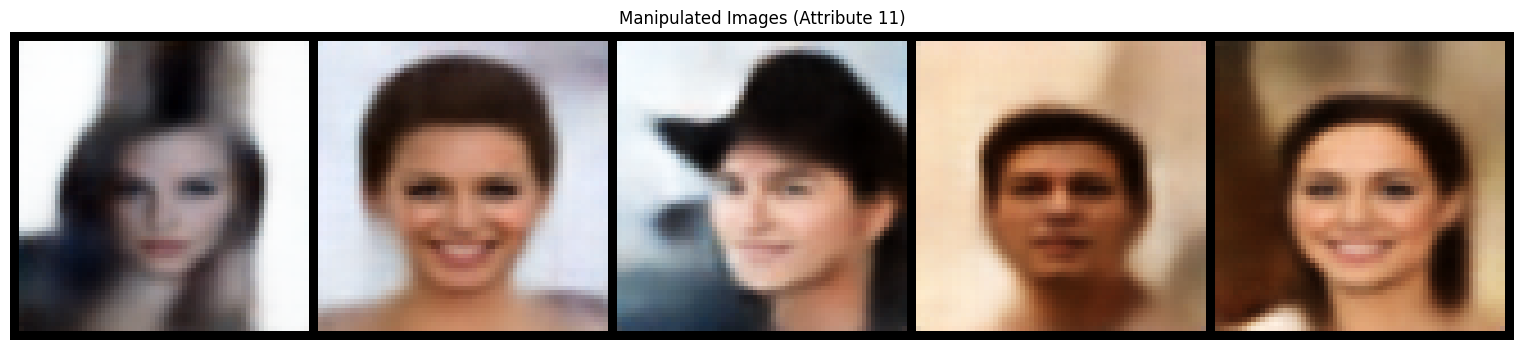

Manipulated attribute: Brown_Hair


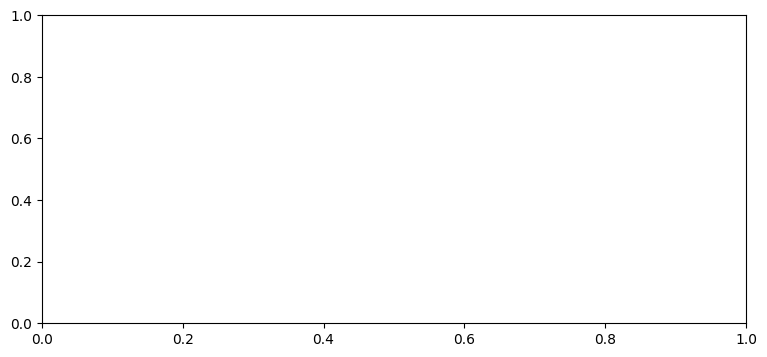

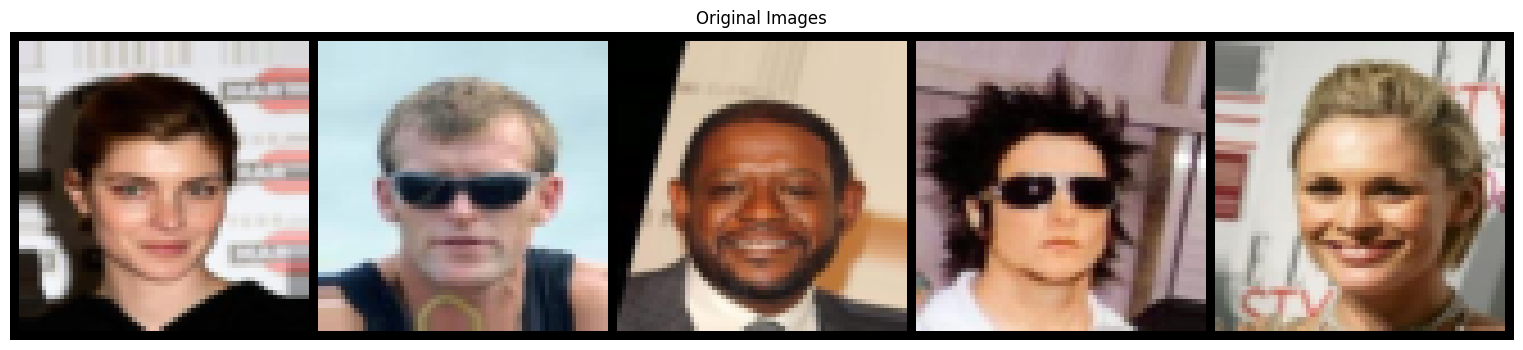

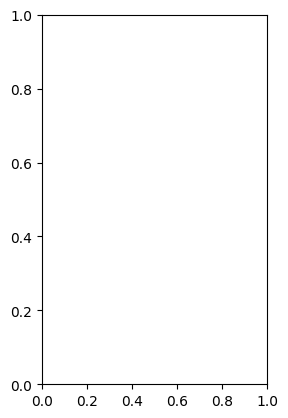

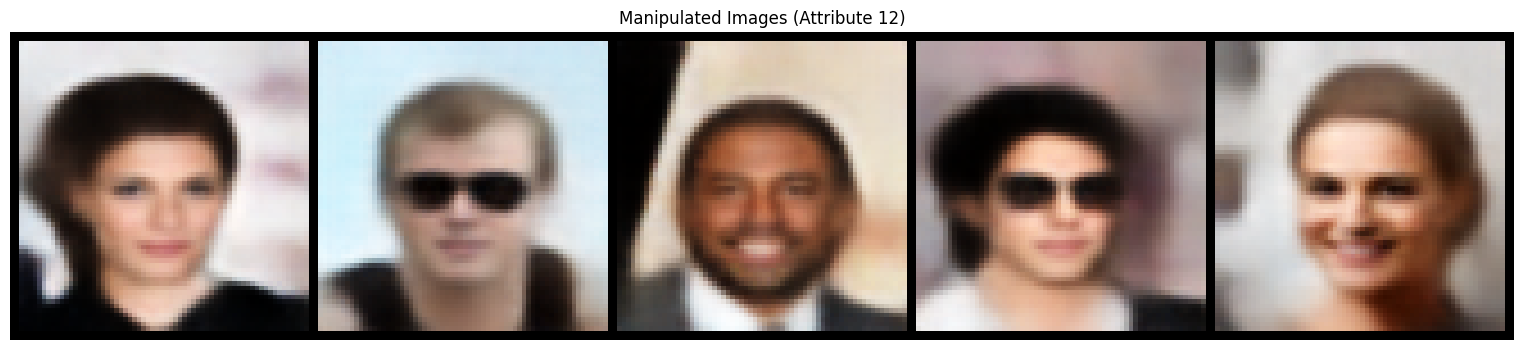

Manipulated attribute: Bushy_Eyebrows


In [ ]:
def visualize_attribute_manipulation(model, dataloader, attr_idx, num_images=5):
    images, attrs = next(iter(dataloader))
    images = images[:num_images].to(device)
    attrs = attrs[:num_images].to(device)

    manipulated_images = []
    for i in range(num_images):
        flipped = flip_attribute(model, images[i], attrs[i], attr_idx)
        manipulated_images.append(flipped[0])

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    show_images(images, num_images=num_images, title="Original Images")
    plt.subplot(1, 2, 2)
    show_images(torch.stack(manipulated_images), num_images=num_images, title=f"Manipulated Images (Attribute {attr_idx})")
    plt.show()

# Visualize attribute manipulation for multiple images
for attr_name, attr_idx in zip(attribute_names, attribute_indices):
    visualize_attribute_manipulation(model, dataloader, attr_idx)
    print(f"Manipulated attribute: {attr_name}")

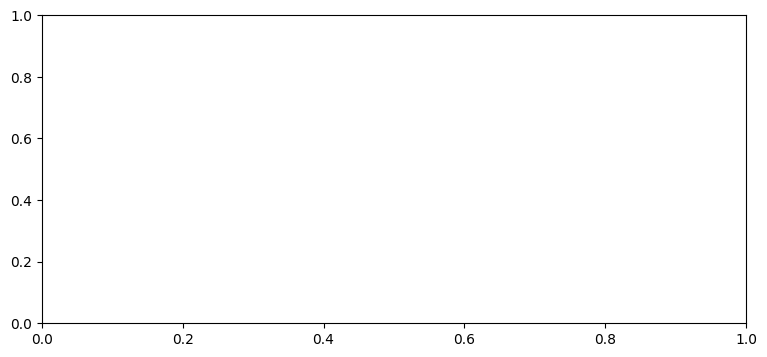

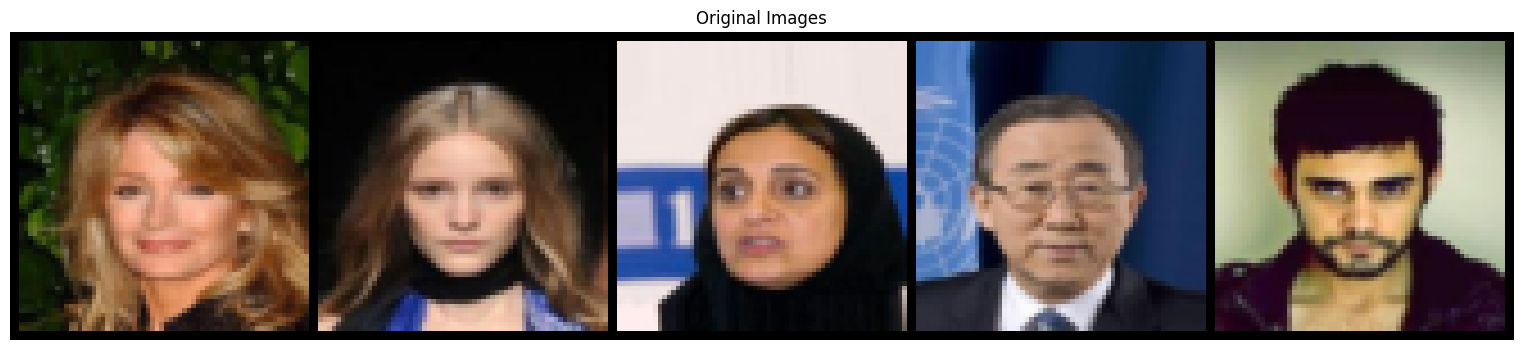

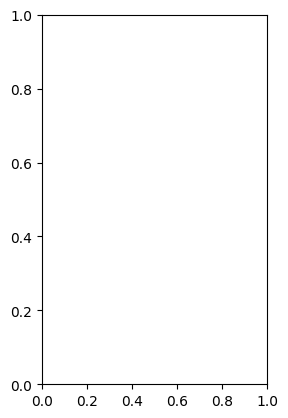

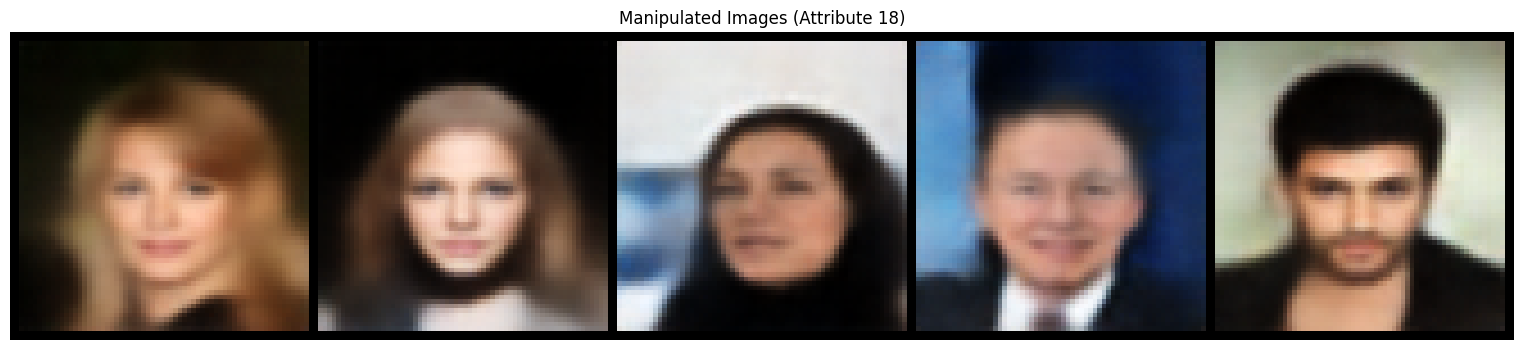

Manipulated attribute: Smiling


In [ ]:
# Select an attribute smile

# Find the index of the "Smiling" attribute
smile_attr_idx = 18  # Index of the "Smiling" attribute in CelebA

# Visualize manipulation of the "Smiling" attribute
visualize_attribute_manipulation(model, dataloader, smile_attr_idx)
print("Manipulated attribute: Smiling")


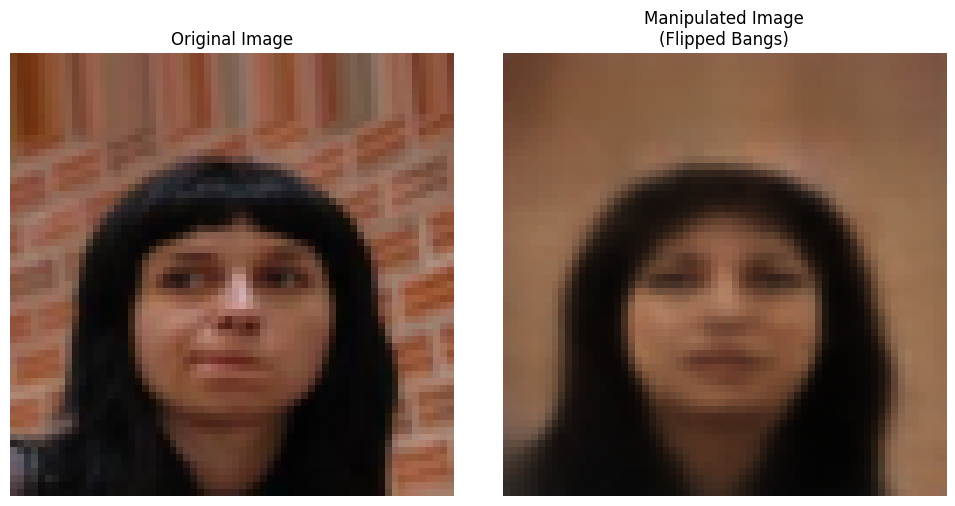

Manipulated attribute: Bangs


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_single_attribute_manipulation(model, dataloader, attr_idx, attr_name):
    # Get a single image and its attributes
    images, attrs = next(iter(dataloader))
    image = images[0].to(device)
    attr = attrs[0].to(device)

    # Manipulate the attribute
    manipulated_image = flip_attribute(model, image, attr, attr_idx)

    # Visualize the original and manipulated images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    show_image(image.cpu())
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    show_image(manipulated_image[0].cpu())
    plt.title(f"Manipulated Image\n(Flipped {attr_name})")

    plt.tight_layout()
    plt.show()

def show_image(img):
    img = img.permute(1, 2, 0)
    img = (img + 1) / 2  # Denormalize
    plt.imshow(img)
    plt.axis('off')

# Assuming you have already defined and trained your model, and set up your dataloader

# List of attributes to manipulate (you can modify this based on CelebA attributes)
attribute_names = ["Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair", "Bushy_Eyebrows"]
attribute_indices = [4, 8, 9, 11, 12]  # Corresponding indices in the attribute vector

# Choose a single attribute to manipulate
chosen_attr_index = 0  # Change this to visualize different attributes

# Visualize attribute manipulation for the chosen attribute
attr_name = attribute_names[chosen_attr_index]
attr_idx = attribute_indices[chosen_attr_index]
visualize_single_attribute_manipulation(model, dataloader, attr_idx, attr_name)
print(f"Manipulated attribute: {attr_name}")

# Another training

- The Second implementation separates the encoder and decoder into distinct classes (CVAEEncoder, CVAEDecoder), while the First implementation combines them into a single CVAE class.

- Second implementation uses BatchNorm and LeakyReLU in the encoder and decoder, while the first uses only ReLU.

In [ ]:
import torch.nn as nn
import torch

class CVAEEncoder(nn.Module):
    def __init__(self, image_channels=3, attr_dim=40, h_dim=1024, z_dim=100):
        super(CVAEEncoder, self).__init__()
        self.image_channels = image_channels
        self.attr_dim = attr_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        self.conv_layers = nn.Sequential(
            nn.Conv2d(image_channels + attr_dim, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.feature_size = self._get_conv_output((image_channels + attr_dim, 64, 64))
        self.fc_mu = nn.Linear(self.feature_size + attr_dim, z_dim)
        self.fc_logvar = nn.Linear(self.feature_size + attr_dim, z_dim)

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self.conv_layers(input)
        return int(output.numel() / output.size(0))

    def forward(self, x, c):
        c_expanded = c.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x_c = torch.cat([x, c_expanded], dim=1)
        h = self.conv_layers(x_c)
        h_flat = h.view(h.size(0), -1)
        h_c = torch.cat([h_flat, c], dim=1)
        return self.fc_mu(h_c), self.fc_logvar(h_c)

class CVAEDecoder(nn.Module):
    def __init__(self, image_channels=3, attr_dim=40, h_dim=1024, z_dim=100):
        super(CVAEDecoder, self).__init__()
        self.image_channels = image_channels
        self.attr_dim = attr_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        self.decoder_input = nn.Linear(z_dim + attr_dim, h_dim)

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(h_dim // 16, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, c):
        z_c = torch.cat([z, c], dim=1)
        h = self.decoder_input(z_c)
        h = h.view(h.size(0), h.size(1) // 16, 4, 4)
        return self.deconv_layers(h)

class CVAE(nn.Module):
    def __init__(self, image_channels=3, attr_dim=40, h_dim=1024, z_dim=100):
        super(CVAE, self).__init__()
        self.encoder = CVAEEncoder(image_channels, attr_dim, h_dim, z_dim)
        self.decoder = CVAEDecoder(image_channels, attr_dim, h_dim, z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, c), mu, logvar

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, attr) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        attr = attr.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, attr)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}')

# Save the model
torch.save(model.state_dict(), 'cvae_celeba.pth')

100%|██████████| 700/700 [01:15<00:00,  9.29it/s]


Epoch 1, Loss: 1202.7338


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 2, Loss: 681.0325


100%|██████████| 700/700 [01:13<00:00,  9.51it/s]


Epoch 3, Loss: 606.1280


100%|██████████| 700/700 [01:14<00:00,  9.35it/s]


Epoch 4, Loss: 572.8661


100%|██████████| 700/700 [01:15<00:00,  9.33it/s]


Epoch 5, Loss: 551.7116


100%|██████████| 700/700 [01:14<00:00,  9.42it/s]


Epoch 6, Loss: 536.4921


100%|██████████| 700/700 [01:14<00:00,  9.42it/s]


Epoch 7, Loss: 528.8933


100%|██████████| 700/700 [01:14<00:00,  9.45it/s]


Epoch 8, Loss: 520.6947


100%|██████████| 700/700 [01:14<00:00,  9.38it/s]


Epoch 9, Loss: 515.1645


100%|██████████| 700/700 [01:14<00:00,  9.40it/s]


Epoch 10, Loss: 507.9540


100%|██████████| 700/700 [01:13<00:00,  9.47it/s]


Epoch 11, Loss: 503.4300


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 12, Loss: 499.1945


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 13, Loss: 493.5188


100%|██████████| 700/700 [01:13<00:00,  9.47it/s]


Epoch 14, Loss: 488.1164


100%|██████████| 700/700 [01:13<00:00,  9.48it/s]


Epoch 15, Loss: 484.6877


100%|██████████| 700/700 [01:14<00:00,  9.36it/s]


Epoch 16, Loss: 480.3564


100%|██████████| 700/700 [01:14<00:00,  9.39it/s]


Epoch 17, Loss: 477.6978


100%|██████████| 700/700 [01:14<00:00,  9.37it/s]


Epoch 18, Loss: 476.2376


100%|██████████| 700/700 [01:13<00:00,  9.46it/s]


Epoch 19, Loss: 473.2403


100%|██████████| 700/700 [01:14<00:00,  9.46it/s]

Epoch 20, Loss: 472.0053


In [ ]:
# Save the model
torch.save(model.state_dict(), 'cvae_celeba.pth')

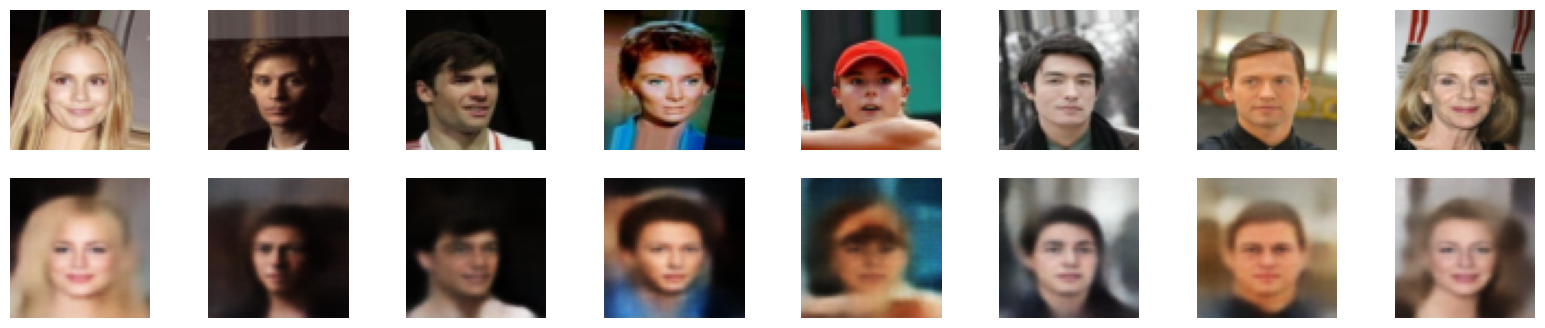

In [ ]:
# Get a batch of test data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Modify labels to add glasses
labels[:, 15] = 1  # Set the 'Eyeglasses' attribute to 1

# Reconstruct images with the modified labels
with torch.no_grad():
  recon_images, _, _ = model(images.to(device), labels.to(device))

# Display the original and reconstructed images
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

  # Display reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(recon_images[i].permute(1, 2, 0).cpu() * 0.5 + 0.5)
  plt.axis('off')

plt.show()
